# School of Electrical and Information Engineering
### University of the Witwatersrand, Johannesburg
### ELEN4022 — Full Stack Quantum Computing
### Laboratory 2 — Qunatum Full Adder
### James Allsop (1110612)
### 11 May 2021

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

#### Half Adder Classical Circuit
A Half Adder is capable of performing the summation of two binary numbers and calculating the "carry bit", if the operation result number is larger than the binary register can hold.
<br/>
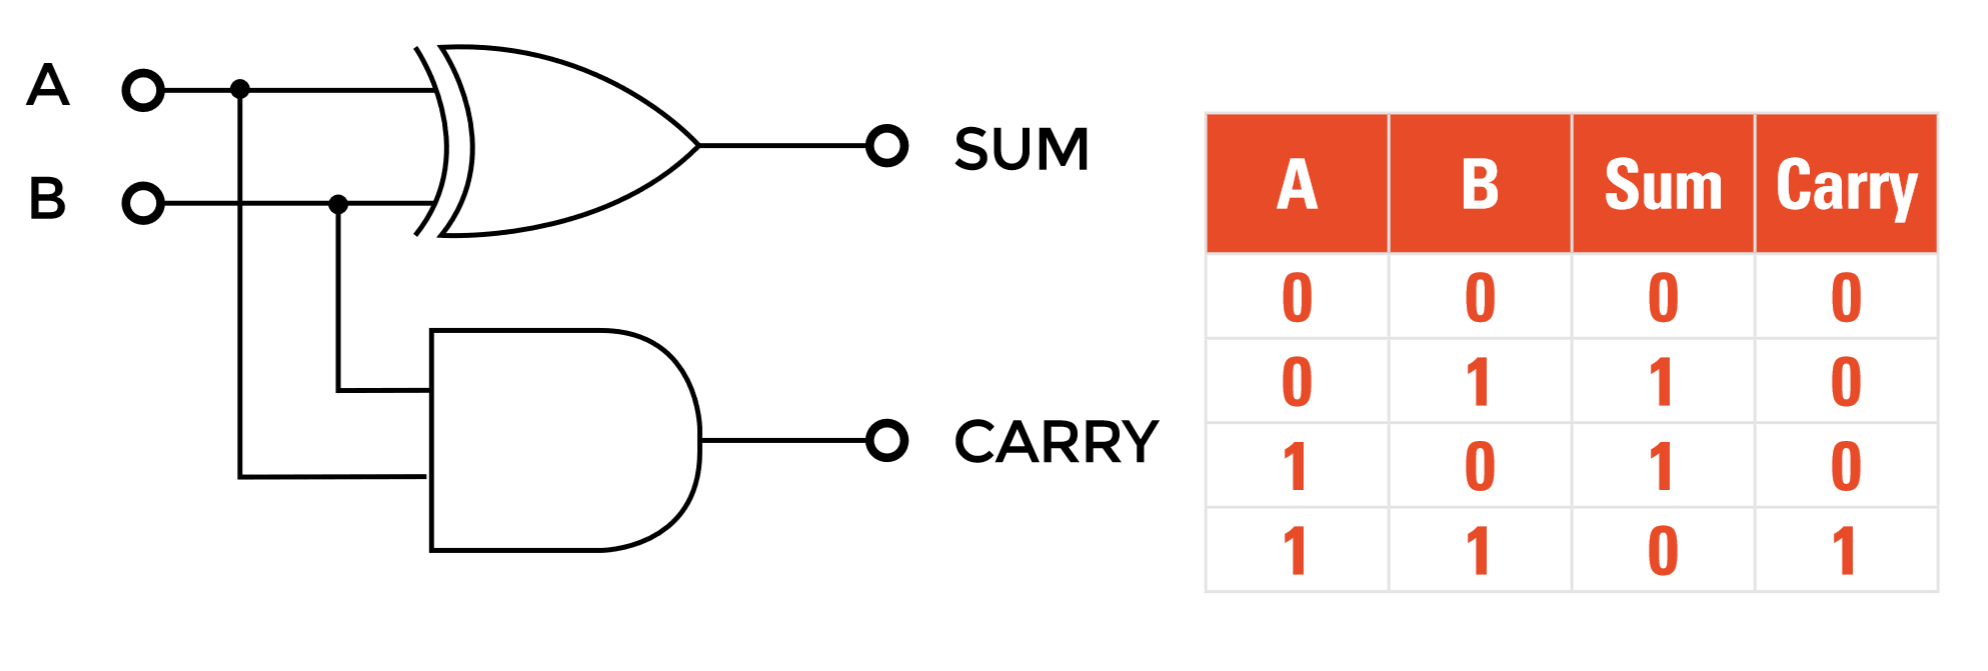
<div align="center">Figure 1: Classical Half Adder Circuit with Truth Table</div>
<br/>
<br/>
As seen in Figure 1 the Half adder is composed of a:
<br/>
<br/>
Exclusive Or (XOR) (the summation of the two numbers) 
<br/>
$$A \oplus B = Sum $$
and a AND gate (carry calculator).
<br/>
$$A . B = Carry $$
<br/>
The XOR gate is capable of "adding" 1 and 0, resulting in 0 if the 1 and 1 is added and the AND gate accounts for the "overflow" if 1 and 1 is added (as is seen in the truth table in Figure 1).

##### Sum Subroutine
In order to implement the half (and full) adder a sum sub routine is created, which is equivalent to the XOR gate in Figure 1. The sum subroutine utilises two CNOT gates to "flip" the output qubit based on the input qubits X and Y. Flipping the output qubit twice (resulting in 0 - the initial state) if both input qubits are 1.

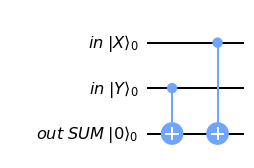

In [2]:
X = QuantumRegister(1, "in |X⟩")
Y = QuantumRegister(1, "in |Y⟩")
sum_out = QuantumRegister(1, "out SUM |0⟩")
SUM = QuantumCircuit(X, Y, sum_out, name='SUM')
SUM.cx(1, 2)
SUM.cx(0, 2)
fig = SUM.draw('mpl', True)
SUM = SUM.to_instruction() #converts circuit to quantum gate compatible with classical bits
fig

#### Half Adder Quantum Circuit
The AND gate quantum equivalent is a Toffoli (or CCNOT) gate. The Toffoli CNOT gate is dependendant on two control qubits (instead of one) - only "flipping" the target qubit if both the control qubits are 1. For the Half Adder circuit below the Toffoli gate is used to flip the Carry qubit on if the input's X and Y are 1. In conjuntion with the SUM subroutine addition is performed.

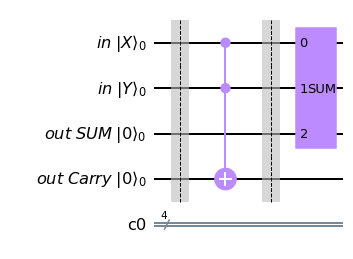

In [3]:
c = ClassicalRegister(4)
cout = QuantumRegister(1, 'out Carry |0⟩')
half_adder = QuantumCircuit(X, Y, sum_out, cout, c)

half_adder.barrier()
half_adder.ccx(0, 1, 3)
half_adder.barrier()
half_adder.append(SUM, [0, 1, 2])
fig = half_adder.draw('mpl', True)
half_adder.measure(X, c[3])
half_adder.measure(Y, c[2])
half_adder.measure(sum_out, c[1])
half_adder.measure(cout ,c[0])
fig

In [4]:
def TruthTable(t, cirq):
    for i in range(2,6):
        print(str(execute(t.compose(cirq),Aer.get_backend('qasm_simulator')).result().get_counts())[i],end = "")
    print("")

#### Half Adder Testing
As can be seen in the results generated below the half adder implemented generates matching results to the truth table in Figure 1.

In [5]:
print("ABSC")
temp = QuantumCircuit(X, Y, sum_out, cout, c)
TruthTable(temp, half_adder)
temp = QuantumCircuit(X, Y, sum_out, cout, c)
temp.x(0)
TruthTable(temp, half_adder)
temp = QuantumCircuit(X, Y, sum_out, cout, c)
temp.x(1)
TruthTable(temp, half_adder)
temp = QuantumCircuit(X, Y, sum_out, cout, c)
temp.x(0)
temp.x(1)
TruthTable(temp, half_adder)
print("\nHalf Adder Truth Table")

ABSC
0000
1010
0110
1101

Half Adder Truth Table


#### Carry Subroutine
The Toffoli gate used for the implementation of the Half Adder is not sufficient for the construction of the Full Adder as the input Carry qubits are not account for. This is required in order to cascade the Half Adders - creating the Full Adder. As such, the following Carry subroutine is implemented. 
<br><br>
As seen below, in addition to the first Tofolli gate (peforming the same function as in the Half Adder).
<br><br>
A CNOT gate is added transforming input Y:
<br>
$$|Y⟩ \rightarrow X\oplus Y $$
<br><br>
The second Tofolli gate then accounts for the Carry in qubit flipping the output qubit to 1 if the now transformed Y is 1. 

To summarise:

- The Output (the carry qubit) is "flipped" to 1 if the input qubits are both 1

- If the input qubits are not both 1, the input qubit Y is "flipped" to 1

- And then if both the (now transformed) input qubit Y and the input Carry qubit are both 1 (which will only occur if both input qubits are not 1) the output qubit is "flipped" to 1.

This enables the cascading of CARRY subroutines to calculated the final Carry output qubit.

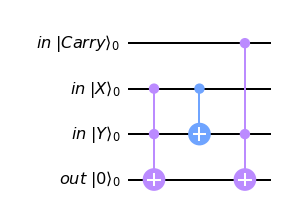

In [6]:
cin = QuantumRegister(1, "in |Carry⟩")
cout = QuantumRegister(1, 'out |0⟩')
CARRY = QuantumCircuit(cin, X, Y, cout, name='CARRY')
CARRY.ccx(1, 2, 3)
CARRY.cx(1, 2)
CARRY.ccx(0, 2, 3)
fig = CARRY.draw('mpl', True)
CARRY = CARRY.to_instruction() #converts circuit to quantum gate compatible with classical bits
fig

#### Carry Testing
As can be seen in the results generated below the new compensated CARRY routine implemented generates matching results to the truth table in Figure 3 (sans the sum bit).

**NOTE** Ć is equivalent to Carry out in the generate results

In [7]:
carry_cirq = QuantumCircuit(cin, X, Y, cout, c)
carry_cirq.append(CARRY, [0, 1, 2, 3])
carry_cirq.cx(1, 2)
carry_cirq.measure(X, c[3])
carry_cirq.measure(Y, c[2])
carry_cirq.measure(cin, c[1])
carry_cirq.measure(cout, c[0])

print("ABCĆ")
temp = QuantumCircuit(cin, X, Y, cout, c)   
TruthTable(temp, carry_cirq)

temp = QuantumCircuit(cin, X, Y, cout, c)
temp.x(cin)
TruthTable(temp, carry_cirq)

temp = QuantumCircuit(cin, X, Y, cout, c)
temp.x(Y)
TruthTable(temp, carry_cirq) 

temp = QuantumCircuit(cin, X, Y, cout, c)
temp.x(cin)
temp.x(Y)
TruthTable(temp, carry_cirq)

temp = QuantumCircuit(cin, X, Y, cout, c)
temp.x(X)
TruthTable(temp, carry_cirq)

temp = QuantumCircuit(cin, X, Y, cout, c)
temp.x(X)
temp.x(Y)
TruthTable(temp, carry_cirq)
temp.x(cin)
TruthTable(temp, carry_cirq)
print("\nCompensated Full Adder Carry Truth Table")

ABCĆ
0000
0010
0100
0111
1000
1101
1111

Compensated Full Adder Carry Truth Table


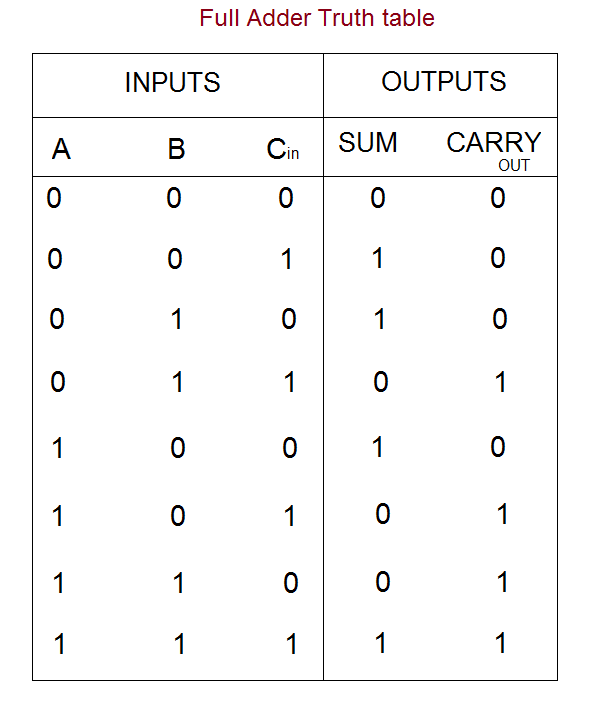

<div align="center">Figure 3: Classical Full Adder Truth Table</div>

In [10]:
from numpy import binary_repr
from qiskit.quantum_info import Statevector

class FullAdder:
    def __init__(self, bits):
        self.n = bits
        self.classical = ClassicalRegister(self.n+1)
        self.A = QuantumRegister(self.n, 'in |A⟩')
        self.B = QuantumRegister(self.n, 'in |B⟩')
        self.Carry = QuantumRegister(self.n+1, 'carry |0⟩')
        self.qc = QuantumCircuit(self.A, self.B, self.Carry, self.classical,
                                 name=(str(bits)+" bit Quantum Full Adder"))
        for i in range(self.n):
            self.qc.append(CARRY, 
                           [self.Carry[i], self.A[i], self.B[i], self.Carry[i+1]])
        self.qc.cx(self.A[self.n-1], self.B[self.n-1])
        for i in range(self.n-1, 0, -1):
            self.qc.append(SUM, [self.Carry[i], self.A[i], self.B[i]])
            self.qc.append(CARRY.inverse(), 
                           [self.Carry[i-1], self.A[i-1], self.B[i-1], self.Carry[i]])
        self.qc.append(SUM, [self.Carry[0], self.A[0], self.B[0]])
        
    def draw(self, case = " "):
        print(self.qc.name)
        if case == "decompose":
            return self.qc.decompose().draw('mpl', True)
        return self.qc.draw('mpl', True)
    
    def add(self, a, b, case = 'sim'):
        temp = QuantumCircuit(self.A, self.B, self.Carry, self.classical)
        for i in range(self.n):
            temp.initialize(Statevector.from_label
                            (binary_repr(a,width=self.n)[::-1][i]), self.A[i])
            temp.initialize(Statevector.from_label
                            (binary_repr(b,width=self.n)[::-1][i]), self.B[i])
        temp = temp.compose(self.qc)
        temp.barrier()    
        for i in range(self.n):
                temp.measure(self.B[i], self.classical[i])
        temp.measure(self.Carry[self.n], self.classical[self.n])
        if case == 'sim': 
            return str(execute(temp,Aer.get_backend('qasm_simulator')).result().get_counts())[2:3+self.n]
        if case == 'hardware':
            return 0
        
    def minus(self, a, b, case = 'sim'):
        temp = self.qc
        self.qc = self.qc.inverse()
        result = self.add(b, a, case)
        self.qc = temp
        return result

3 bit Quantum Full Adder


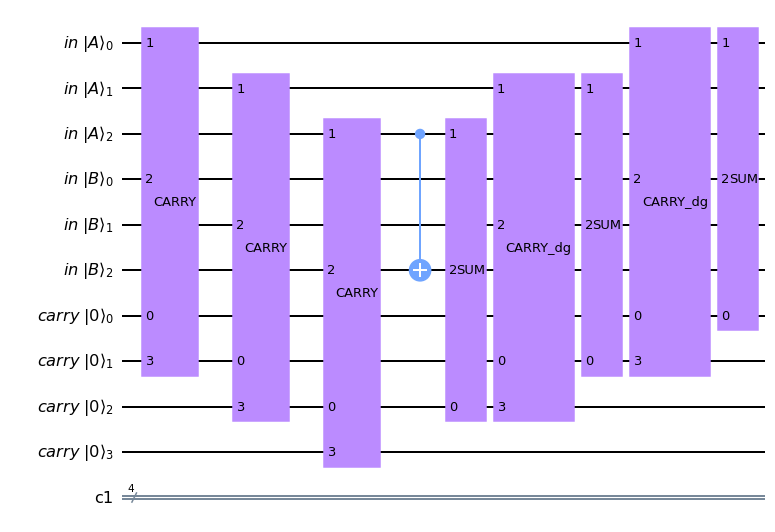

In [11]:
ThreeBit = FullAdder(bits = 3)
ThreeBit.draw()

In [12]:
result = ThreeBit.add(2,3)
print("2 + 3 = 0b" + result + " = " + str(int(result,2)))

2 + 3 = 0b0101 = 5


In [13]:
result = ThreeBit.add(5,3)
print("5 + 3 = 0b" + result + " = " + str(int(result,2)))

5 + 3 = 0b1000 = 8


In [14]:
result = ThreeBit.add(7,7)
print("7 + 7 = 0b" + result + " = " + str(int(result,2)))

7 + 7 = 0b1110 = 14


In [15]:
result = ThreeBit.minus(4,3)
print("4 - 3 = 0b" + result + " = " + str(int(result,2)))

4 - 3 = 0b0001 = 1
